# Variational Autoencoder - MNIST & TensorFlow2

[Reference](https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/#creating-a-vae-with-keras)

In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.7.0


In [3]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: Tesla K80


In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

In [5]:
# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [7]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (28, 28, 1)


In [8]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 100

In [9]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [10]:
# By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks
# work best when each input is inside the range –1 to 1, so we need to divide by 255.

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [ ]:
# Convert class vectors/target to binary class matrices or one-hot encoded values-
# y_train = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [11]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (60000, 28, 28, 1), y_train.shape: (60000,)
X_test.shape: (10000, 28, 28, 1), y_test.shape: (10000,)


In [12]:
# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(128)

# Needed by 'tf.GradientTape()' API for custom training and testing code.

### Define _Variational Autoencoder_ architecture using convolutional layers

In [13]:
class Encoder(Model):
    def __init__(self, latent_space = 3):
        super(Encoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.conv1 = Conv2D(
            filters = 32, kernel_size = 3,
            strides = (2, 2), activation = None
        )
        
        self.conv2 = Conv2D(
            filters = 64, kernel_size = 3,
            strides = (2, 2), activation = None
        )
        
        self.conv3 = Conv2D(
            filters = 64, kernel_size = 3,
            strides = (2, 2), activation = None
        )
        
        self.flatten = Flatten()

        self.dense = Dense(units = self.latent_space, activation = None)
        
        # self.dense = Dense(units = self.latent_space + self.latent_space, activation = None)
        
        
    def call(self, x):
        x = tf.keras.activations.relu(self.conv1(x))
        # print(f"conv1.shape: {x.shape}")
        # conv1.shape: (None, 13, 13, 32)
        x = tf.keras.activations.relu(self.conv2(x))
        # print(f"conv2.shape: {x.shape}")
        # conv2.shape: (3, 6, 6, 64)
        x = tf.keras.activations.relu(self.conv3(x))
        # print(f"conv3.shape: {x.shape}")
        # conv3.shape: (3, 2, 2, 64)
        x = self.flatten(x)
        # print(f"flattened shape: {x.shape}")
        # flattened shape: (None, 256)
        x = tf.keras.activations.relu(self.dense(x))
        # print(f"encoder output shape: {x.shape}")
        # encoder output shape: (None, 3)
        
        return x


In [14]:
class Decoder(Model):
    def __init__(self, latent_space = 3):
        super(Decoder, self).__init__()
            
        self.latent_space = latent_space
        
        self.dense = Dense(units = self.latent_space, activation = None)
        self.dense2 = Dense(units = 2 * 2 * 64, activation = None)
        self.reshape = Reshape(target_shape = (2, 2, 64))
        
        # K = 3, S = 2, P = 0-
        self.conv2d_tran = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 2, padding = 'valid',
            activation = None
        )
        
        # K = 5, S = 2, P = 0-
        self.conv2d_tran2 = Conv2DTranspose(
            filters = 32, kernel_size = 5,
            strides = 2, padding = 'valid',
            activation = None
        )
        
        # K = 4, S = 2, P = 0-
        self.conv2d_output = Conv2DTranspose(
            filters = 1, kernel_size = 4,
            strides = 2, padding = 'valid'
        )
       
    
    def call(self, x):
        x = tf.keras.activations.relu(self.dense(x))
        # print(f"dense1.shape: {x.shape}")
        # dense1.shape: (3, 3)
        x = tf.keras.activations.relu(self.dense2(x))
        # print(f"dense2.shape: {x.shape}")
        # dense2.shape: (3, 256)
        x = self.reshape(x)
        # print(f"reshape.shape: {x.shape}")
        # reshape.shape: (3, 2, 2, 64)
        x = tf.keras.activations.relu(self.conv2d_tran(x))
        # print(f"conv2d_tran1.shape: {x.shape}")
        # conv2d_tran1.shape: (3, 5, 5, 64)
        x = tf.keras.activations.relu(self.conv2d_tran2(x))
        # print(f"conv2d_tran2.shape: {x.shape}")
        # conv2d_tran2.shape: (3, 13, 13, 32)
        # x = tf.keras.activations.sigmoid(self.conv2d_output(x))
        x = self.conv2d_output(x)
        return x
        

In [15]:
class VAE(Model):
    def __init__(self, latent_space = 3):
        super(VAE, self).__init__()
        
        self.latent_space = latent_space
        
        self.encoder = Encoder(latent_space = self.latent_space)
        self.decoder = Decoder(latent_space = self.latent_space)
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mean, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(shape = mean.shape)
        return (eps * tf.exp(logvar * 0.5) + mean)
        
    
    def call(self, x):
        x = self.encoder(x)
        # print(f"x.shape: {x.shape}")
        # x.shape: (batch_size, 3)
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        # mu.shape: (batch_size, 3), log_var.shape: (batch_size, 3) & z.shape: (batch_size, 3)
        '''
        x = tf.keras.activations.sigmoid(self.decoder(z))
        return x, mu, log_var
        

In [16]:
# Initialize VAE model-
model = VAE(latent_space = 3)

In [17]:
# Sanity check-
X = X_train[:4, :]

In [18]:
# Forward pass using input data-
X_recon, mu, log_var = model(X)

In [19]:
X.shape, X_recon.shape

((4, 28, 28, 1), TensorShape([4, 28, 28, 1]))

In [20]:
mu.shape, log_var.shape

(TensorShape([4, 3]), TensorShape([4, 3]))

In [21]:
mu.numpy().mean(), mu.numpy().std()

(0.024246616, 0.03830287)

In [22]:
log_var.numpy().mean(), log_var.numpy().std()

(0.018621068, 0.019040756)

In [23]:
del X, X_recon, mu, log_var

In [24]:
# Get model summary-
model.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  56515     
                                                                 
 decoder (Decoder)           multiple                  89709     
                                                                 
 dense_3 (Dense)             multiple                  12        
                                                                 
 dense_4 (Dense)             multiple                  12        
                                                                 
Total params: 146,248
Trainable params: 146,248
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Count layer-wise number of trainable parameters-
tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} parameters")

layer: (3, 3, 1, 32) has 288 parameters
layer: (32,) has 0 parameters
layer: (3, 3, 32, 64) has 18432 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 64) has 36864 parameters
layer: (64,) has 0 parameters
layer: (256, 3) has 768 parameters
layer: (3,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters
layer: (3, 256) has 768 parameters
layer: (256,) has 0 parameters
layer: (3, 3, 64, 64) has 36864 parameters
layer: (64,) has 0 parameters
layer: (5, 5, 32, 64) has 51200 parameters
layer: (32,) has 0 parameters
layer: (4, 4, 1, 32) has 512 parameters
layer: (1,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters
layer: (3, 3) has 9 parameters
layer: (3,) has 0 parameters


In [26]:
print(f"VAE has {tot_params} trainable parameters")

VAE has 145723 trainable parameters


In [27]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [28]:
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):
    
    # Reconstruction loss-
    # recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))

    recon_loss = tf.reduce_mean(
        tf.reduce_sum(
            # tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            tf.keras.losses.mean_squared_error(data, reconstruction),
            axis = (1, 2)
            )
        )
    
    # KL-divergence loss-    
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))

    total_loss = (recon_loss * alpha) + kl_loss
    
    return total_loss, recon_loss, kl_loss
    

In [ ]:
"""
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):
    
    # Reconstruction loss-
    recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))
    
    # KL-divergence loss-
    kl_loss = -0.5 * (1 + log_var - K.square(mu) - K.exp(log_var))
    # kl_loss = K.sum(kl_loss, axis = -1)
    # kl_loss = K.mean(kl_loss)
    kl_loss = K.mean(K.sum(kl_loss, axis = -1))
    
    total_loss = (recon_loss * alpha) + kl_loss
    
    return total_loss, recon_loss, kl_loss
"""

In [ ]:
'''
total_loss, recon_loss, kl_loss = compute_loss(
    data = X, reconstruction = X_recon,
    mu = mu, log_var = log_var,
    alpha = 1
)
'''

In [ ]:
# total_loss
# <tf.Tensor: shape=(), dtype=float32, numpy=0.23451519>

In [29]:
@tf.function
def train_one_step(model, optimizer, data, alpha):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        X_recon, mu, log_var = model(data)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = data, reconstruction = X_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )
    
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # type(grads), len(grads)
    # (list, 20)
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, recon_loss, kl_loss


In [30]:
@tf.function
def test_step(model, optimizer, data, alpha):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    X_recon, mu, log_var = model(data)
    
    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_loss(
        data = data, reconstruction = X_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )
    
    return total_loss, recon_loss, kl_loss


In [ ]:
'''
total_loss = train_one_step(
    model = model, optimizer = optimizer,
    data = X, alpha = 1
)
'''

In [ ]:
# total_loss
# <tf.Tensor: shape=(), dtype=float32, numpy=0.23313756>

In [31]:
# Python3 dict to contain training metrics-
training_metrics = {}
val_metrics = {}

In [32]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence-
alpha = 1

In [33]:
for epoch in range(1, 16):
    
    # Epoch train & validation losses-
    train_loss = 0.0
    train_r_loss = 0.0
    train_kl_l = 0.0
    val_loss = 0.0
    val_r_loss = 0.0
    val_kl_l = 0.0
    
    for data in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = data, alpha = alpha
        )
        
        train_loss += train_total_loss.numpy()
        train_r_loss += train_recon_loss.numpy()
        train_kl_l += train_kl_loss.numpy()
    
    for test_data in test_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha)
        
        val_loss += test_total_loss.numpy()
        val_r_loss += test_recon_loss.numpy()
        val_kl_l += test_kl_loss.numpy()
    
    # vae_train_loss.append(train_loss)
    # vae_val_loss.append(val_loss)

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_r_loss,
        'kl_loss': train_kl_l
        }
    
    val_metrics[epoch] = {
        'total_loss': val_loss, 'recon_loss': val_r_loss,
        'kl_loss': val_kl_l
    }

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
    f" val kl loss = {val_kl_l:.4f}"
    )
    

epoch = 1; total train loss = 56287.9695, train recon loss = 55164.7875, train kl loss = 1123.1818; total val loss = 6637.7301, val recon loss = 6545.8331 & val kl loss = 91.8970
epoch = 2; total train loss = 33841.7761, train recon loss = 33691.8412, train kl loss = 149.9349; total val loss = 4891.0861, val recon loss = 4878.0104 & val kl loss = 13.0756
epoch = 3; total train loss = 25410.7366, train recon loss = 25109.0074, train kl loss = 301.7292; total val loss = 4129.9294, val recon loss = 4052.0479 & val kl loss = 77.8815
epoch = 4; total train loss = 24196.9590, train recon loss = 23759.1442, train kl loss = 437.8148; total val loss = 4059.7438, val recon loss = 3975.8174 & val kl loss = 83.9264
epoch = 5; total train loss = 23863.7835, train recon loss = 23352.3825, train kl loss = 511.4011; total val loss = 3998.1020, val recon loss = 3908.7131 & val kl loss = 89.3890
epoch = 6; total train loss = 23656.9250, train recon loss = 23082.9820, train kl loss = 573.9430; total val 

In [34]:
# Sanity check for Python3 dicts containing training metrics-
training_metrics.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [35]:
val_metrics.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [36]:
training_metrics[5].keys()

dict_keys(['total_loss', 'recon_loss', 'kl_loss'])

In [37]:
val_metrics[5].keys()

dict_keys(['total_loss', 'recon_loss', 'kl_loss'])

In [38]:
# Save trained model-
model.save_weights("VAE_MNIST_trained.h5", overwrite = True)

### Visualize training metrics

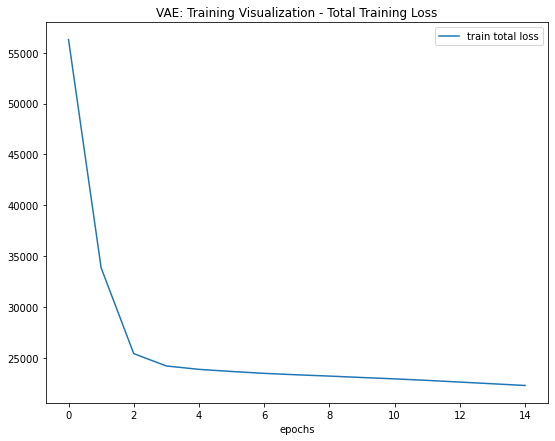

In [39]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_loss'] for e in training_metrics.keys()], label = 'train total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Training Loss")
plt.show()

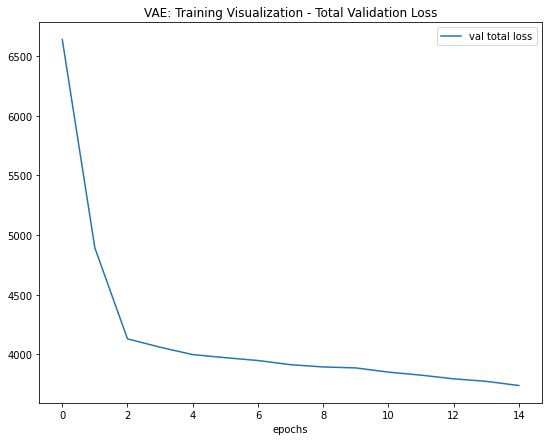

In [40]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['total_loss'] for e in val_metrics.keys()], label = 'val total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Validation Loss")
plt.show()

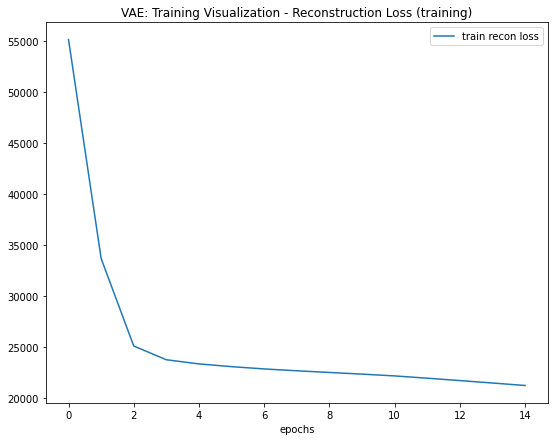

In [41]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_loss'] for e in training_metrics.keys()], label = 'train recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (training)")
plt.show()

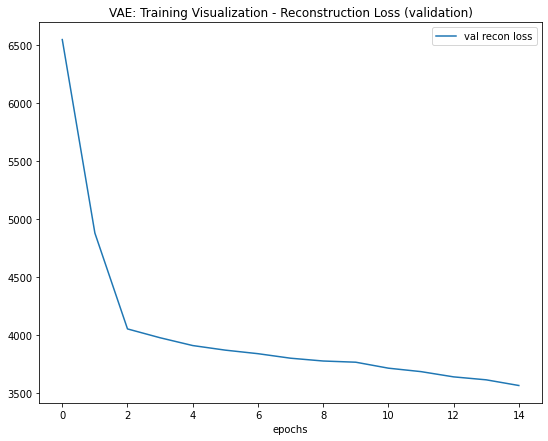

In [42]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['recon_loss'] for e in val_metrics.keys()], label = 'val recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (validation)")
plt.show()

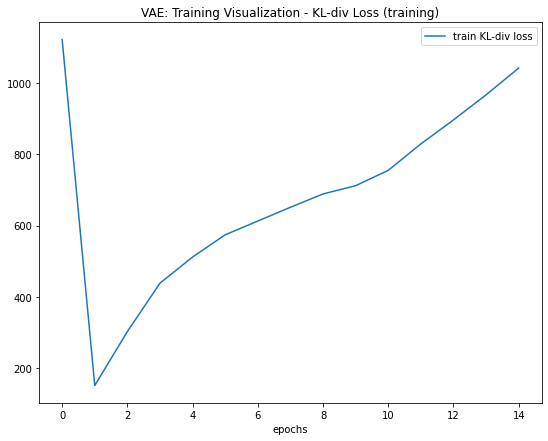

In [43]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['kl_loss'] for e in training_metrics.keys()], label = 'train KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (training)")
plt.show()

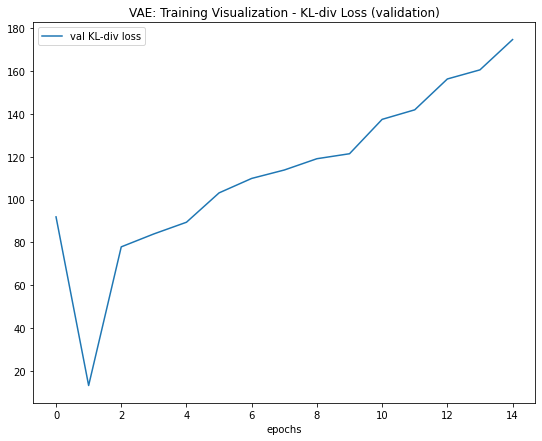

In [44]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['kl_loss'] for e in val_metrics.keys()], label = 'val KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (validation)")
plt.show()

### Visualize _reconstructions_ using trained VAE model

In [45]:
# Get reconstructions, mean & log-variance from trained model-
X_train_reconstruced, mu, log_var = model(X_train[:1000, :])

In [46]:
# Sanity check-
X_train[:1000, :].shape, X_train_reconstruced.shape

((1000, 28, 28, 1), TensorShape([1000, 28, 28, 1]))

In [47]:
X_train_reconstruced = tf.reshape(
    tensor = X_train_reconstruced,
    shape = ((X_train_reconstruced.shape[0], X_train_reconstruced.shape[1], X_train_reconstruced.shape[2] )),
    name = None
    )

In [48]:
# Sanity check-
X_train_reconstruced.numpy().shape

(1000, 28, 28)

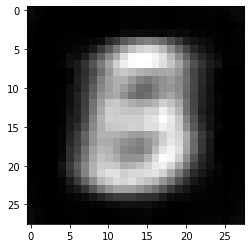

In [49]:
# Visualize a single digit-
plt.imshow(X_train_reconstruced[0], cmap = plt.get_cmap('gray'))
plt.show()

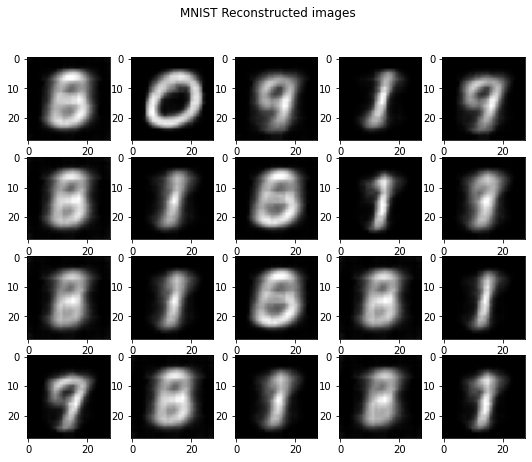

In [66]:
# Visualize 10 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i], cmap = plt.get_cmap('gray'))
    
plt.suptitle("MNIST Reconstructed images")
plt.show()

#### Check _mu_ and _log_var_ latent space vectors:

In [52]:
mu.shape, log_var.shape

(TensorShape([1000, 3]), TensorShape([1000, 3]))

In [53]:
print(f"mu: mean = {mu.numpy().mean():.4f} & "
f"std dev = {mu.numpy().std():.4f}")

mu: mean = 0.2501 & std dev = 0.8941


In [54]:
print(f"log var: mean = {log_var.numpy().mean():4f} &"
f" std dev = {log_var.numpy().std():.4f}")

log var: mean = -1.271232 & std dev = 0.7668


### Visualize _mean_ and _log-variance_ of _latent space_ using trained VAE model

In [55]:
fig = px.scatter_3d(
    x = mu[:, 0], y = mu[:, 1],
    z = mu[:, 2],
    color = y_train[:1000]
    )
fig.show()

In [56]:
fig = px.scatter_3d(
    x = log_var[:, 0], y = log_var[:, 1],
    z = log_var[:, 2],
    color = y_train[:1000]
    )
fig.show()

### Visualize _latent space_ of train & test datasets

In [57]:
X_train_encoded = model.encoder(X_train)
X_test_encoded = model.encoder(X_test)

In [58]:
X_train.shape, X_train_encoded.shape

((60000, 28, 28, 1), TensorShape([60000, 3]))

In [59]:
X_test.shape, X_test_encoded.shape

((10000, 28, 28, 1), TensorShape([10000, 3]))

In [60]:
fig = px.scatter_3d(
    x = X_train_encoded[:, 0], y = X_train_encoded[:, 1],
    z = X_train_encoded[:, 2],
    color = y_train
)
fig.show()

In [61]:
fig = px.scatter_3d(
    x = X_test_encoded[:, 0], y = X_test_encoded[:, 1],
    z = X_test_encoded[:, 2],
    color = y_test
)
fig.show()

In [62]:
del X_train_encoded, X_test_encoded